<a href="https://colab.research.google.com/github/mazenmagdii/MRI-Brain-Classification/blob/main/MRI_Brain_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
!unzip brain-mri-images-for-brain-tumor-detection.zip -d brain_tumor_dataset

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 33% 5.00M/15.1M [00:00<00:00, 46.1MB/s]
100% 15.1M/15.1M [00:00<00:00, 103MB/s] 
Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/brain_tumor_dataset/n

In [ ]:
path_No = ("brain_tumor_dataset/no/*")
path_Yes = ("brain_tumor_dataset/yes/*")

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D, ZeroPadding2D
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall,Precision
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from PIL import Image
from tensorflow.keras.layers import Input
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50

In [ ]:
tumor = []
no_tumor = []
random_state = 42

for file in glob.iglob(path_Yes):
    img = cv2.imread(file)      #Reading the images from the path
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        #Changing the color from BGR to RGB
    img = cv2.resize(img, (128, 128))
    tumor.append((img, 1))  # Appending tuple with image and label 1 (indicating presence of tumor)

for file in glob.iglob(path_No):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    no_tumor.append((img, 0))  # Appending tuple with image and label 0 (indicating absence of tumor)

# Concatenating the two lists and shuffle the data
all_data = tumor + no_tumor


# Splitting data and labels
data = np.array([item[0] for item in all_data])
labels = np.array([item[1] for item in all_data])

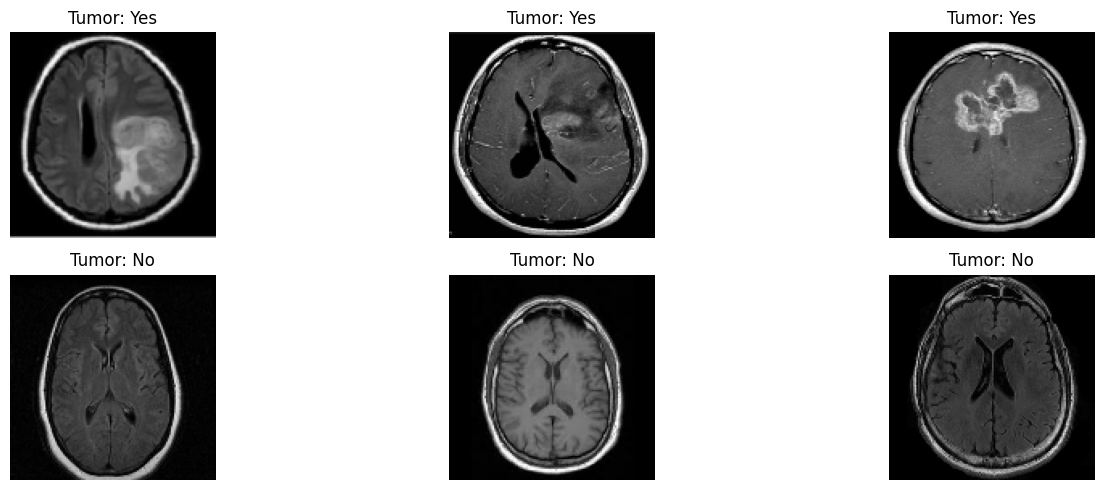

In [ ]:
plt.figure(figsize=(15, 5))

# Display tumor images with label 'yes'
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(tumor[i][0])
    plt.title("Tumor: Yes")
    plt.axis('off')

# Display no_tumor images with label 'no'
for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(no_tumor[i][0])
    plt.title("Tumor: No")
    plt.axis('off')

plt.tight_layout()
plt.show()

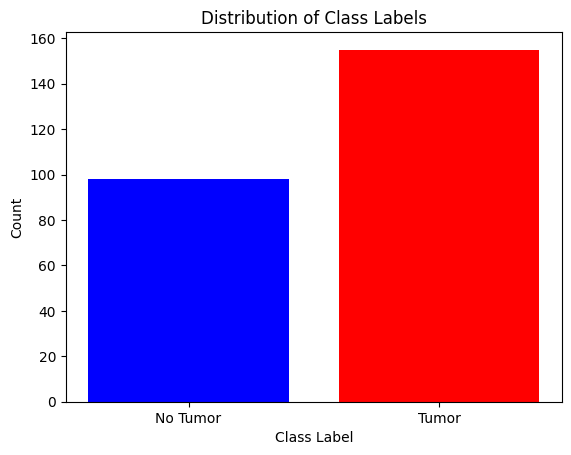

In [ ]:
unique_labels, label_counts = np.unique(labels, return_counts=True)

plt.bar(unique_labels, label_counts, color=['blue', 'red'])
plt.xticks(unique_labels, ['No Tumor', 'Tumor'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

x_train, x_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.30, random_state=42, shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.50, random_state=42, shuffle=True)

datagen = ImageDataGenerator(
    rotation_range=15,
    #width_shift_range=0.1,
    #height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    #brightness_range=[0.8, 1.2]
)

datagen.fit(x_train)

augmented_images = []
augmented_labels = []
for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=128):
    augmented_images.extend(x_batch)
    augmented_labels.extend(y_batch)
    if len(augmented_images) >= 7500:  # Augment up to the size of the original training set
        break

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

x_train = np.concatenate([x_train, augmented_images])
y_train = np.concatenate([y_train, augmented_labels])

x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


0

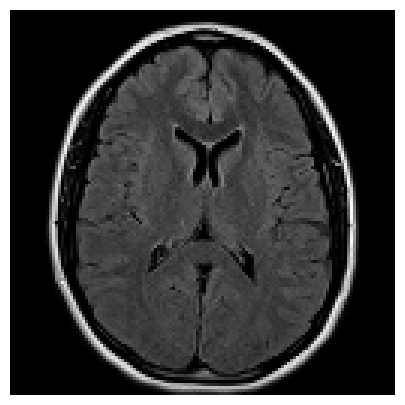

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(x_test[10 ])
plt.axis('off')
y_test[10]

In [ ]:
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.3),
    Dense(80, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 32)        128       
 chNormalization)                                                
                                                        

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
es=EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=35)
mc=ModelCheckpoint(filepath="/content/drive/MyDrive/Final_Project/best_model1.keras",monitor='val_accuracy',mode='max',verbose=1,save_best_only=True,save_weights_only=True)
rlr=ReduceLROnPlateau(monitor='val_accuracy',mode='max',verbose=1,patience=7,min_lr=0.000001)

In [ ]:
history=model.fit(x_train,y_train,epochs=150,validation_data=(x_val,y_val),batch_size=128,shuffle=True,callbacks=[es,mc,rlr])

Epoch 1/150
61/61 [==============================] - ETA: 0s - loss: 0.0171 - accuracy: 0.9920
Epoch 1: val_accuracy did not improve from 0.94737
61/61 [==============================] - 27s 435ms/step - loss: 0.0171 - accuracy: 0.9920 - val_loss: 0.5956 - val_accuracy: 0.9211 - lr: 1.0000e-06
Epoch 2/150
61/61 [==============================] - ETA: 0s - loss: 0.0163 - accuracy: 0.9937
Epoch 2: val_accuracy did not improve from 0.94737
61/61 [==============================] - 27s 435ms/step - loss: 0.0163 - accuracy: 0.9937 - val_loss: 0.6005 - val_accuracy: 0.9211 - lr: 1.0000e-06
Epoch 3/150
61/61 [==============================] - ETA: 0s - loss: 0.0167 - accuracy: 0.9928
Epoch 3: val_accuracy did not improve from 0.94737
61/61 [==============================] - 27s 435ms/step - loss: 0.0167 - accuracy: 0.9928 - val_loss: 0.6036 - val_accuracy: 0.8947 - lr: 1.0000e-06
Epoch 4/150
33/61 [===============>..............] - ETA: 12s - loss: 0.0189 - accuracy: 0.9927

In [ ]:
model.load_weights('/content/drive/MyDrive/Final_Project/best_model1.keras')
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'Model\'s accuracy: {test_acc * 100:.1f}%')


2/2 - 0s - loss: 1.9561 - accuracy: 0.8158 - 72ms/epoch - 36ms/step
Model's accuracy: 81.6%
